In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib

In [2]:
inputFile="../data/labeled/labeled_dataV1.csv"
df = pd.read_csv(inputFile)
#df=df[1:500000]

# our categories and their related words
classes=['unisex', 'men', 'women', 'kid', 'baby']
 



labeled_data=df[df['class']!= '-1'].copy()

#encode the classes to their index 
labeled_data['labels']=labeled_data['class'].apply( classes.index)
print(classes)


['unisex', 'men', 'women', 'kid', 'baby']


In [3]:
# Helper Functions

def plot_class_distribution (data_frame, groupby_feature,class_name, starting_index=0):
    grouped  = data_frame.groupby([class_name]) 
    values=grouped[groupby_feature].agg(np.size)[starting_index:]  
    labels =  values.index.tolist()  
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values)
    plt.xticks(y_pos, labels)
    plt.xlabel('Product categories')
    plt.ylabel('Number of Products')
    plt.show()


# Bag of Words Counts 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,2))
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer


list_corpus = labeled_data["all_text"].tolist()
list_labels = labeled_data["labels"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, 
                                                    list_labels, test_size=0.2,
                                                     random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

X_train_counts.shape

(47360, 148955)

## Visualizing the embeddings
Since visualizing data in large dimensions is hard, let's project it down to 2.

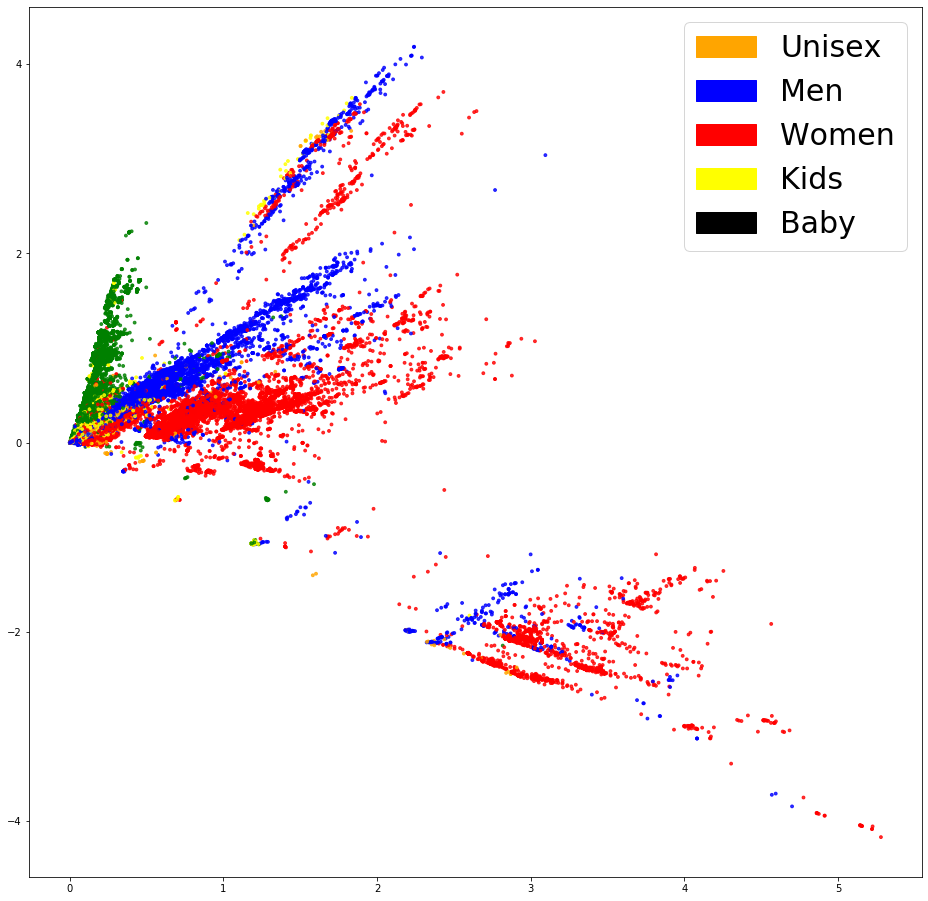

In [5]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','red', 'yellow', 'green']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Unisex')
            blue_patch = mpatches.Patch(color='blue', label='Men')
            red_patch = mpatches.Patch(color='red', label='Women')
            yellow_patch = mpatches.Patch(color='yellow', label='Kids')
            green_patch = mpatches.Patch(color='black', label='Baby')
            plt.legend(handles=[orange_patch, blue_patch, red_patch,yellow_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [6]:
#display(df.head())
#display(labeled_data.head())

print(df.shape)
print(labeled_data.shape)

(500000, 19)
(59200, 20)


## Fitting logistic regression


In [7]:

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

## Let's see how confident is our classifier 

In [8]:
allRecords_probabilty=clf.predict_proba(X_test_counts)

allRecords_max_probabilty = []
for i in range(0, allRecords_probabilty.shape[0]):
    probablities=allRecords_probabilty[i]
    prob_index= np.argmax(probablities)
    prob_max= max(probablities)
    allRecords_max_probabilty.append(prob_max)
    


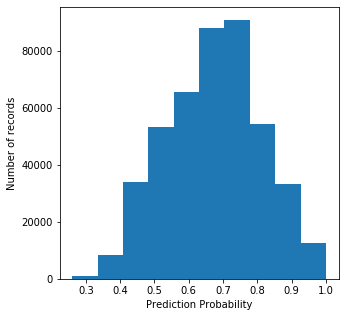

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5)) 
plt.xlabel('Prediction Probability')
plt.ylabel('Number of records')
plt.hist(allRecords_max_probabilty)
plt.show()

## Evaluation

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.998, precision = 0.998, recall = 0.998, f1 = 0.998


## Inspection
 Let's start by looking at the confusion matrix.

In [11]:

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

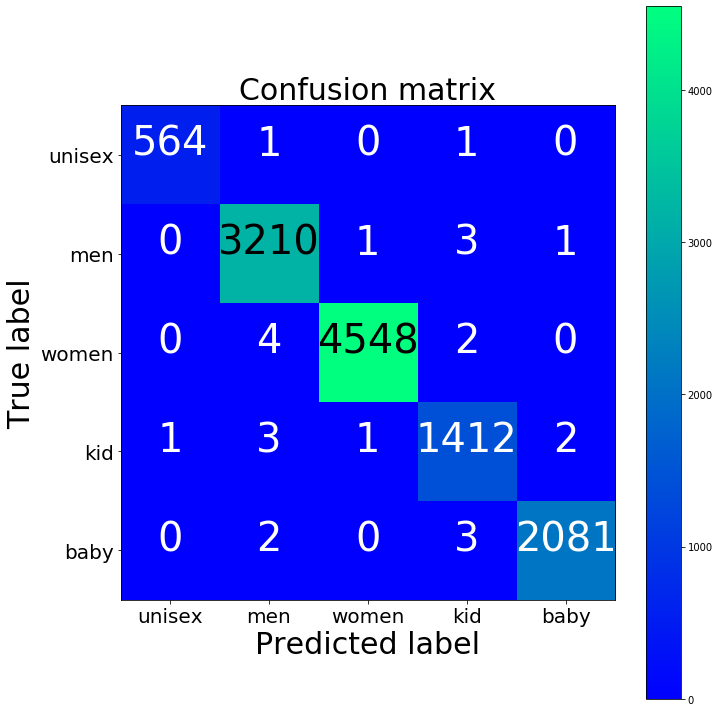

[[ 564    1    0    1    0]
 [   0 3210    1    3    1]
 [   0    4 4548    2    0]
 [   1    3    1 1412    2]
 [   0    2    0    3 2081]]


In [12]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=classes, normalize=False, title='Confusion matrix')
plt.show()
print(cm)

## Further inspection
Let's look at the features our classifier is using to make decisions.

In [13]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 15)


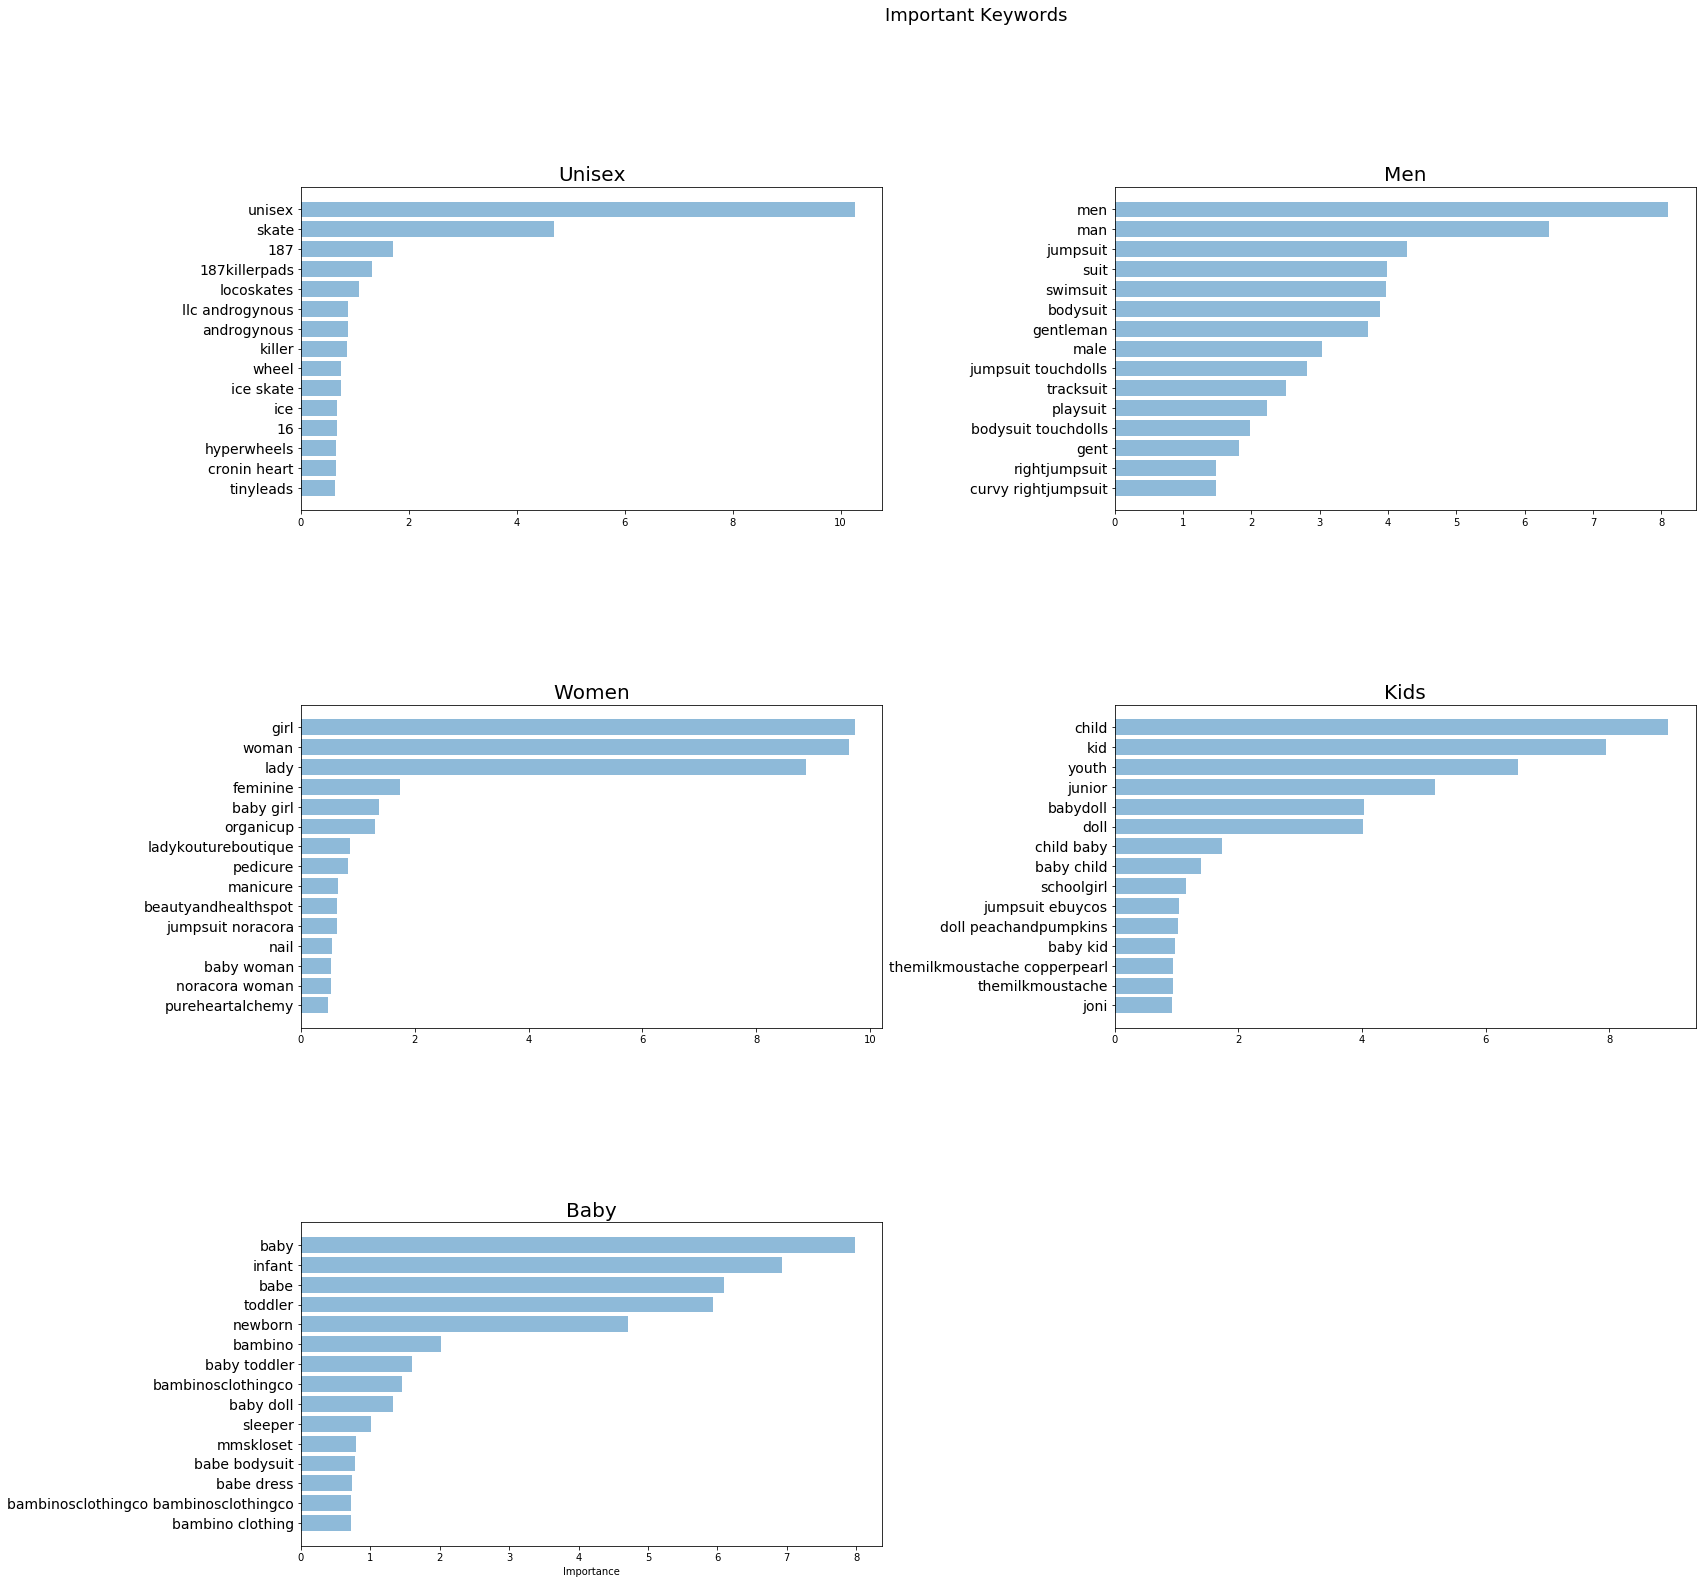

In [14]:


def plot_important_words( top_words, top_scores, label, position):

    y_pos = np.arange(len(top_words))
    plt.subplot(position)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title(label, fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)




top_scores_unisex = [a[0] for a in importance[0]['tops']]
top_words_unisex = [a[1] for a in importance[0]['tops']]

top_scores_men = [a[0] for a in importance[1]['tops']]
top_words_men = [a[1] for a in importance[1]['tops']]

top_scores_women = [a[0] for a in importance[2]['tops']]
top_words_women = [a[1] for a in importance[2]['tops']]

top_scores_kid = [a[0] for a in importance[3]['tops']]
top_words_kid = [a[1] for a in importance[3]['tops']]

top_scores_baby = [a[0] for a in importance[4]['tops']]
top_words_baby = [a[1] for a in importance[4]['tops']]

#plot_important_words(top_scores_unisex, top_words_unisex, top_scores_men, top_words_men, "Most important words")


unisex_pairs = [(a,b) for a,b in zip(top_words_unisex, top_scores_unisex)]
men_pairs = [(a,b) for a,b in zip(top_words_men, top_scores_men)]
unisex_pairs = [(a,b) for a,b in zip(top_words_unisex, top_scores_unisex)]
men_pairs = [(a,b) for a,b in zip(top_words_men, top_scores_men)]

fig = plt.figure(figsize=(25, 25))  
plot_important_words(top_words_unisex, top_scores_unisex, "Unisex", 321)   
plot_important_words(top_words_men, top_scores_men, "Men", 322)
plot_important_words(top_words_women, top_scores_women, "Women", 323)
plot_important_words(top_words_kid, top_scores_kid, "Kids", 324)
plot_important_words(top_words_baby, top_scores_baby, "Baby", 325)

plt.subplots_adjust(wspace=0.4, hspace = 0.6)
plt.suptitle("Important Keywords", fontsize=18)
plt.xlabel('Importance')
plt.show()

In [15]:
#from pivottablejs import pivot_ui
#pivot_ui(labeled_data )

## let's see how our CLF model performs on unseen data
We can use the prediction probability as a performance metric

In [16]:
unlabeled_data= df[df['class'] == '-1'].copy()
print(unlabeled_data.shape)
display(unlabeled_data.head())

(440800, 19)


,Unnamed: 0,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,unisex,men,women,baby,kid,class,all_text
0,0,['cookware'],['hestan'],"['hestan', 'nanobond', 'stainless', '3qt', '2'...",['atlantagrilpany'],['hestanculinary'],[],290.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Stainless 3qt/...,hestan,"['cookware', 'hestan', 'hestan', 'nanobond', '...",0,0,0,0,0,-1,cookware hestan hestan nanobond stainless 3qt ...
1,1,['cookware'],['hestan'],"['hestan', 'nanobond', 'titanium', 'stockpot',...",['atlantagrilpany'],['hestanculinary'],[],450.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Titanium Stock...,hestan,"['cookware', 'hestan', 'hestan', 'nanobond', '...",0,0,0,0,0,-1,cookware hestan hestan nanobond titanium stock...
2,2,['skillet'],['hestan'],"['hestan', 'nanobond', '8', '5', ""''"", 'open',...",['dasallas'],['hestanculinary'],[],189.95,https://dasallas.com/products/hestan-nanobond-...,"Skillets Hestan Hestan Nanobond 8.5"" Open Skil...",hestan,"['skillet', 'hestan', 'hestan', 'nanobond', '8...",0,0,0,0,0,-1,skillet hestan hestan nanobond 8 5 '' open ski...
3,3,"['saucepan', 'sauciers']",['hestan'],"['hestan', 'nanobond', '5', 'quart', 'cover', ...",['dasallas'],['hestanculinary'],[],499.95,https://dasallas.com/products/hestan-nanobond-...,Saucepans & Sauciers Hestan Hestan Nanobond 5-...,hestan,"['saucepan', 'sauciers', 'hestan', 'hestan', '...",0,0,0,0,0,-1,saucepan sauciers hestan hestan nanobond 5 qua...
4,4,['cookware'],['hestan'],"['hestan', 'probond', 'forge', 'stainless', 's...",['atlantagrilpany'],['hestanculinary'],[],799.99,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan ProBond Forged Stainles...,hestan,"['cookware', 'hestan', 'hestan', 'probond', 'f...",0,0,0,0,0,-1,cookware hestan hestan probond forge stainless...


In [17]:


list_corpus = unlabeled_data["all_text"].tolist()
#list_labels = unlabeled_data["labels"].tolist()
X_test_counts = count_vectorizer.transform(list_corpus)
y_test_counts = clf.predict(X_test_counts)

# add prediction to the unlabeled_data dataframe
unlabeled_data['labels']=y_test_counts
unlabeled_data['class']=unlabeled_data['labels'].apply( classes.__getitem__)
print(X_test_counts.shape)

(440800, 148955)


In [18]:
allRecords_probabilty=clf.predict_proba(X_test_counts)

allRecords_max_probabilty = []
for i in range(0, allRecords_probabilty.shape[0]):
    probablities=allRecords_probabilty[i]
    prob_index= np.argmax(probablities)
    prob_max= max(probablities)
    allRecords_max_probabilty.append(prob_max)

# add prediction probability to the unlabeled_data dataframe
unlabeled_data['probability']= allRecords_max_probabilty
unlabeled_data.head()

,Unnamed: 0,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,...,all_tokens,unisex,men,women,baby,kid,class,all_text,labels,probability
0,0,['cookware'],['hestan'],"['hestan', 'nanobond', 'stainless', '3qt', '2'...",['atlantagrilpany'],['hestanculinary'],[],290.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Stainless 3qt/...,...,"['cookware', 'hestan', 'hestan', 'nanobond', '...",0,0,0,0,0,men,cookware hestan hestan nanobond stainless 3qt ...,1,0.740280
1,1,['cookware'],['hestan'],"['hestan', 'nanobond', 'titanium', 'stockpot',...",['atlantagrilpany'],['hestanculinary'],[],450.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Titanium Stock...,...,"['cookware', 'hestan', 'hestan', 'nanobond', '...",0,0,0,0,0,men,cookware hestan hestan nanobond titanium stock...,1,0.707237
2,2,['skillet'],['hestan'],"['hestan', 'nanobond', '8', '5', ""''"", 'open',...",['dasallas'],['hestanculinary'],[],189.95,https://dasallas.com/products/hestan-nanobond-...,"Skillets Hestan Hestan Nanobond 8.5"" Open Skil...",...,"['skillet', 'hestan', 'hestan', 'nanobond', '8...",0,0,0,0,0,men,skillet hestan hestan nanobond 8 5 '' open ski...,1,0.683981
3,3,"['saucepan', 'sauciers']",['hestan'],"['hestan', 'nanobond', '5', 'quart', 'cover', ...",['dasallas'],['hestanculinary'],[],499.95,https://dasallas.com/products/hestan-nanobond-...,Saucepans & Sauciers Hestan Hestan Nanobond 5-...,...,"['saucepan', 'sauciers', 'hestan', 'hestan', '...",0,0,0,0,0,men,saucepan sauciers hestan hestan nanobond 5 qua...,1,0.735230
4,4,['cookware'],['hestan'],"['hestan', 'probond', 'forge', 'stainless', 's...",['atlantagrilpany'],['hestanculinary'],[],799.99,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan ProBond Forged Stainles...,...,"['cookware', 'hestan', 'hestan', 'probond', 'f...",0,0,0,0,0,men,cookware hestan hestan probond forge stainless...,1,0.816444


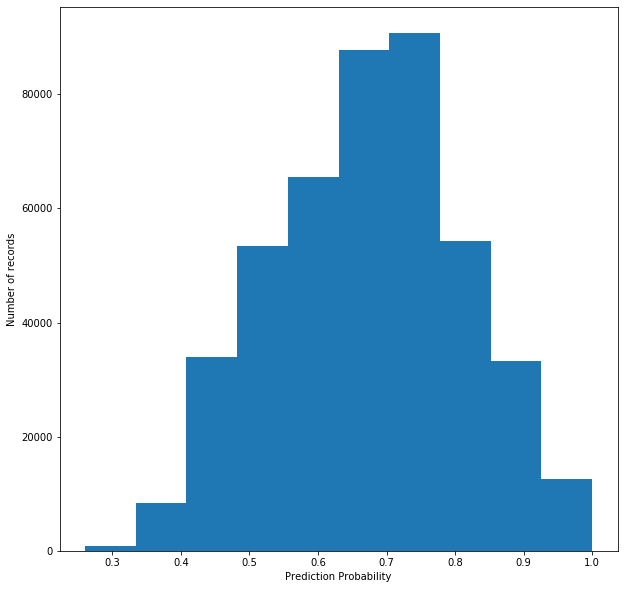

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Prediction Probability')
plt.ylabel('Number of records')
plt.hist(allRecords_max_probabilty)
plt.show()

In [20]:
confidence_threshold=0.8
high_confidence=unlabeled_data[unlabeled_data['probability']>= confidence_threshold] 
high_confidence_size=high_confidence.shape[0]
low_confidence_size=unlabeled_data.shape[0]-  high_confidence_size
print( "Number of records predicted with high confidence is {} out of {}".format( high_confidence_size, unlabeled_data.shape[0]))
print( "Number of records predicted with low confidence is {} out of {}".format( low_confidence_size, unlabeled_data.shape[0]))

Number of records predicted with high confidence is 81928 out of 440800
Number of records predicted with low confidence is 358872 out of 440800


## Let's select 10 random records and check their prediction manually

In [21]:
import random 

random_records=random.sample(high_confidence.index.to_list(), k=10) 
print(random_records)
unlabeled_data.loc[random_records]

[279422, 24060, 232448, 424918, 119950, 277194, 417304, 313590, 370334, 176826]


,Unnamed: 0,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,...,all_tokens,unisex,men,women,baby,kid,class,all_text,labels,probability
279422,279422,"['projector', 'video', 'switcher']",['roland'],"['roland', 'swit', '7108r', 'polarity', 'rever...",['musicredone'],['roland'],[],36.79,https://musicredone.com/products/roland-swit-s...,Projectors & Video Switcher Roland Roland SWIT...,...,"['projector', 'video', 'switcher', 'roland', '...",0,0,0,0,0,men,projector video switcher roland roland swit 71...,1,0.892121
24060,24060,"['limited', 'edition', 'print']","['anya', 'brock']","[""'keep"", 'still', ""''"", 'print']",['anyabrock'],['anyabrock'],[],80.0,https://anyabrock.com/products/keep-me-still-p...,Limited Edition Prints Anya Brock 'Keep Me Sti...,...,"['limited', 'edition', 'print', 'anya', 'brock...",0,0,0,0,0,men,limited edition print anya brock 'keep still '...,1,0.910163
232448,232448,"['glass', 'frame']",['jinsted'],"['luxury', 'high', 'quality', 'leopard', 'prin...","['jinsted', 'co', 'uk']","['jinsted', 'co', 'uk']",[],25.99,https://jinsted.co.uk/products/fr006,Glasses Frames Jinsted Luxury High Quality Leo...,...,"['glass', 'frame', 'jinsted', 'luxury', 'high'...",0,0,0,0,0,men,glass frame jinsted luxury high quality leopar...,1,0.963289
424918,424918,"['cbd', 'pet']","['hemp', 'bomb']","['hemp', 'bomb', '(', '300mg', ')', '30ml', 'p...",['hawaiicbdshop'],['hempbombs'],[],32.0,https://hawaiicbdshop.com/products/hemp-bombs-...,CBD for PETS HEMP BOMBS Hemp Bombs (300mg) 30m...,...,"['cbd', 'pet', 'hemp', 'bomb', 'hemp', 'bomb',...",0,0,0,0,0,men,cbd pet hemp bomb hemp bomb ( 300mg ) 30ml pet...,1,0.948827
119950,119950,[],"['mon', 'ami', 'clothing']","['red', 'short', 'sleeve', 'v', 'neck', 'tie',...",['monamiclothing'],['monamiclothing'],[],48.0,https://monamiclothing.com/products/red-short-...,nan Mon Ami Clothing Red Short Sleeve V Neck T...,...,"['mon', 'ami', 'clothing', 'red', 'short', 'sl...",0,0,0,0,0,men,mon ami clothing red short sleeve v neck tie f...,1,0.911479
277194,277194,"['guitar', 'amplifier', 'combo']",['roland'],"['roland', 'cube', 'street', 'battery', 'power...",['matchettsmusic'],['roland'],[],229.0,https://matchettsmusic.com/products/roland-cub...,Guitar Amplifier Combo Roland Roland CUBE Stre...,...,"['guitar', 'amplifier', 'combo', 'roland', 'ro...",0,0,0,0,0,men,guitar amplifier combo roland roland cube stre...,1,0.817669
417304,417304,[],"['bobby', 'fresh']","['fresh', '11', 'low', 'white', 'tee']",['bobbyfresh'],['bobbyfresh'],[],30.0,https://bobbyfresh.com/products/been-fresh-11-...,nan Bobby Fresh Been Fresh 11 Low White Tee bo...,...,"['bobby', 'fresh', 'fresh', '11', 'low', 'whit...",0,0,0,0,0,men,bobby fresh fresh 11 low white tee bobbyfresh ...,1,0.832517
313590,313590,"['burp', 'cloth']","['copper', 'pearl']","['burp', 'cloth', 'set', 'urban']",['4kidsonlyonline'],['copperpearl'],[],24.99,https://4kidsonlyonline.com/products/burp-clot...,burp cloths Copper Pearl Burp Cloth Set- Urban...,...,"['burp', 'cloth', 'copper', 'pearl', 'burp', '...",0,0,0,0,0,baby,burp cloth copper pearl burp cloth set urban 4...,4,0.839395
370334,370334,[],['weddingconfetti'],"['kastine', 'black', 'illusion', 'long', 'slee...","['weddingconfetti', 'sg']","['weddingconfetti', 'sg']",[],85.0,https://weddingconfetti.sg/products/brand-new-...,nan WeddingConfetti The Kastine Black Illusion...,...,"['weddingconfetti', 'kastine', 'black', 'illus...",0,0,0,0,0,men,weddingconfetti kastine black illusion long sl...,1,0.955349
176826,176826,['art'],"['piece', 'piece', 'interior']","['spray', 'heal']",['piecebypieceinteriors'],['piecebypieceinteriors'],[],0.0,https://piecebypieceinteriors.com/products/spr...,Art Piece by Piece Interiors SPRAY HEAL pieceb...,...,"['art', 'piece', 'piece', 'interior', 'spray',...",0,0,0,0,0,men,art piece piece interior spray heal piecebypie...,1,0.945267


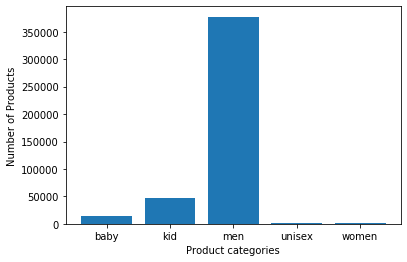

-1        440800
women      22873
men        16201
baby       10354
kid         7051
unisex      2721
Name: class, dtype: int64


In [22]:
plot_class_distribution (unlabeled_data, 'product_type','class', starting_index=0)
print(df['class'].value_counts())

In [23]:
pd.options.display.max_colwidth = 100
rows=unlabeled_data['class']=='baby'
print(unlabeled_data.loc[rows,['class','all_text_original', 'probability']])
pd.options.display.max_colwidth=50

       class  \
585     baby   
586     baby   
595     baby   
597     baby   
598     baby   
...      ...   
494513  baby   
494519  baby   
494659  baby   
494793  baby   
494818  baby   

                                                                                          all_text_original  \
585             Jewellery Damsel Resin Hoop Earrings - Clay mirrormirrorboutique.co.nz damselindior.com nan   
586     Jewellery Damsel Classic Bead Hoop Earrings - Silver mirrormirrorboutique.co.nz damselindior.com...   
595              Jewellery Damsel 3 Hoops Earrings - Silver mirrormirrorboutique.co.nz damselindior.com nan   
597      Jewellery Damsel Classic Bead Hoop Earrings - Gold mirrormirrorboutique.co.nz damselindior.com nan   
598             Earrings Damsel Damsel Classic Gold Bead Hoop Earring baxandberg.co.nz damselindior.com nan   
...                                                                                                     ...   
494513       Nap Mats Stephen 

In [24]:
pd.options.display.max_colwidth=50